In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

from sneakers_ml.features.sift import get_sift_features

In [2]:
def create_dataset(features_, classes_, idx_to_class, images_) -> pd.DataFrame:
    dataframe = pd.DataFrame(
        np.concatenate([features_, classes_.reshape(-1, 1), images_.reshape(-1, 1)], axis=1),
        columns=["feature_1", "feature_2", "class", "image"],
    )
    dataframe["feature_1"] = pd.to_numeric(dataframe["feature_1"])
    dataframe["feature_2"] = pd.to_numeric(dataframe["feature_2"])
    dataframe["class_name"] = dataframe["class"].apply(lambda x: idx_to_class[int(x)])
    top_classes = dataframe["class_name"].value_counts()[:10].index.to_list()
    return dataframe[dataframe["class_name"].isin(top_classes)]

# Получение эмбеддингов resnet для картинок по брендам

In [3]:
features, classes, class_to_idx, kmeans, vector_for_kmeans_save = get_sift_features(
    "data/training/brands-classification", 2000, kmeans=None
)

  0%|          | 0/5309 [00:00<?, ?it/s]

  0%|          | 0/5309 [00:00<?, ?it/s]

  0%|          | 0/5309 [00:00<?, ?it/s]

In [3]:
# features, classes, class_to_idx = load_features("data/features/brands-classification/hog.pickle")

In [4]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes_idx = classes[:, 1]
images_idx = classes[:, 0]

# Сжатие с помощью SVD до двух компонент

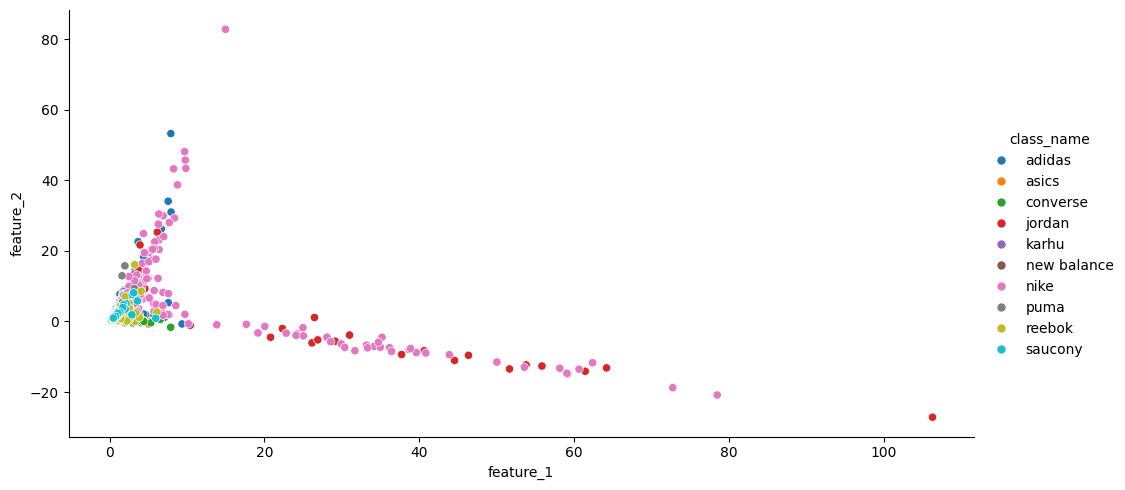

In [5]:
SVD_2 = TruncatedSVD(n_components=2).fit_transform(features)
dataframe = create_dataset(SVD_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Сжатие с помощью PCA до двух компонент

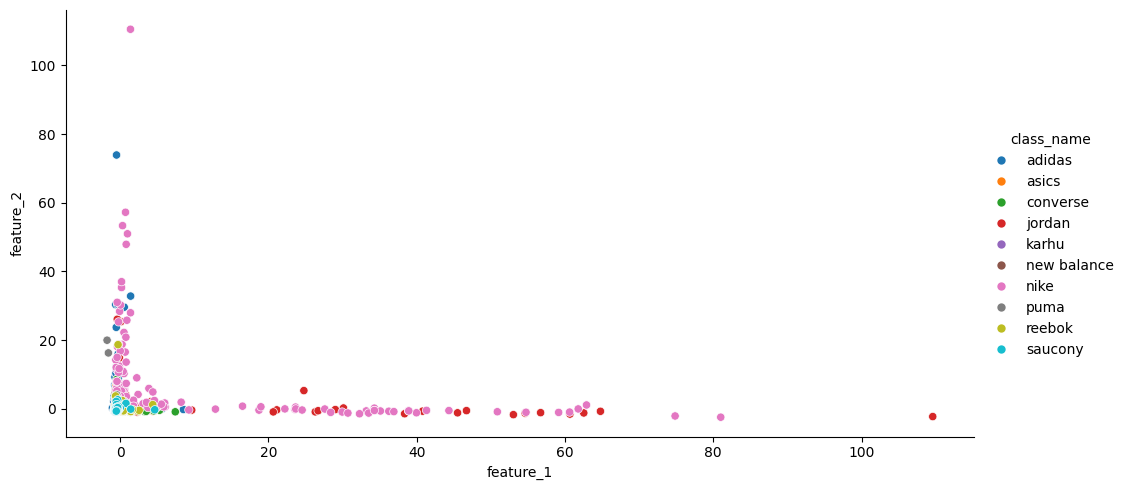

In [6]:
PCA_2 = PCA(n_components=2).fit_transform(features)
dataframe = create_dataset(PCA_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# TSNE до двух компонент (сначала сжимаем с помощью PCA до 50 компонент, потом уже TSNE до двух)

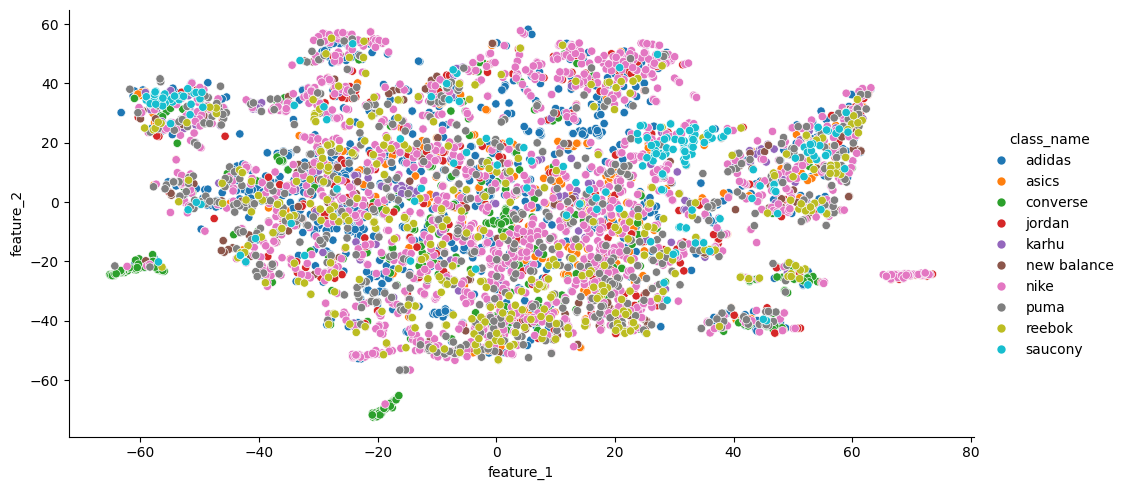

In [7]:
PCA_50 = PCA(n_components=50).fit_transform(features)
TSNE_2 = TSNE(n_components=2).fit_transform(PCA_50)
dataframe = create_dataset(TSNE_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Видны кластеры, но они не соответствуют брендам - скорее всего они кучкуются по *ракурсам* изображений.

# Сделаем UMAP и посмотрим какие картинки в кластерах!!

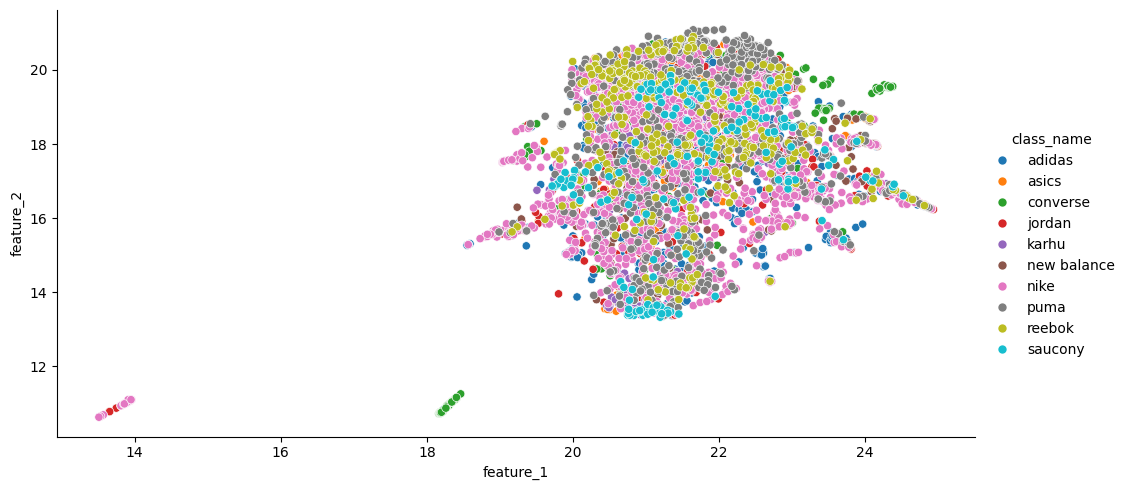

In [8]:
umap_model = UMAP(n_components=2, n_jobs=-1)
umap_embeddings = umap_model.fit_transform(features)
dataframe = create_dataset(umap_embeddings, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Посмотрим можно ли удалить дубликаты - картинки с похожими эмбеддингами

In [9]:
similarity_matrix = cosine_similarity(features)
threshold = 0.95
paths = list(classes[:, 0])

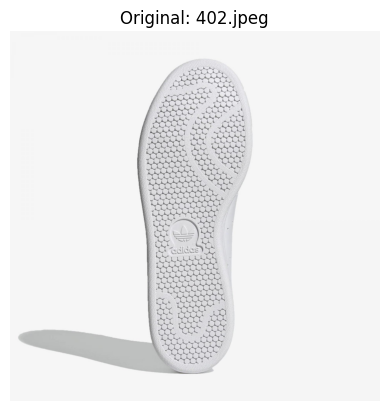

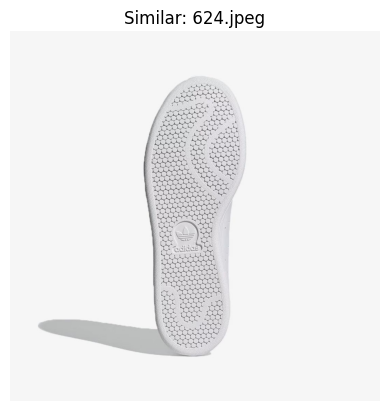

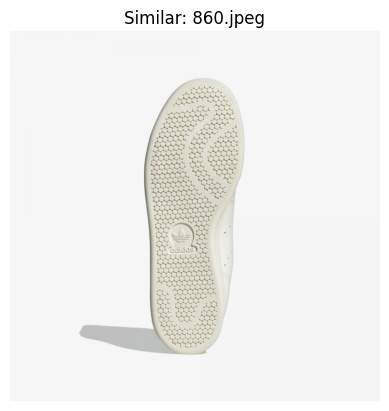

In [10]:
for i in range(len(paths)):
    similar_indices = np.where(similarity_matrix[i] > threshold)[0]

    if len(similar_indices) > 2:
        current_image_path = paths[i]
        current_image = Image.open(current_image_path)
        plt.imshow(current_image)
        plt.title(f"Original: {os.path.basename(current_image_path)}")
        plt.axis("off")
        plt.show()

        for idx in similar_indices:
            if idx != i:
                similar_image_path = paths[idx]
                similar_image = Image.open(similar_image_path)

                plt.imshow(similar_image)
                plt.title(f"Similar: {os.path.basename(similar_image_path)}")
                plt.axis("off")
                plt.show()
        break